In [1]:
%load_ext autoreload
%autoreload 2

import sys

# add to path
sys.path.append('./pyMOSChar')

import lookupMOS as lk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

# import control as ct
from scipy import signal
from scipy import interpolate

# %matplotlib widget
# %matplotlib notebook

# Extract transistor database using pyMOSChar

In [37]:
import charMOS

# Specify the name of the MOSFET model.
nmos = "nmos_3p3"
pmos = "pmos_3p3"

# Specify the MOSFET width in microns.
width = 10

# Specify the MOSFET lengths you're interested in.
mosLengths = np.concatenate((
    np.arange(0.28, 1, 0.2),
    np.arange(1, 10, 2)
))
# mosLengths = np.arange(0.28, 1, 0.2)

# Initialize the characterization process.
charMOS.init(
simulator='ngspice',
mosLengths=mosLengths,
modelFiles=("models/ngspice/sm141064.ngspice",),
modelN=nmos,
modelP=pmos,
simOptions="",
corners=("typical",),
subcktPath="m0",
datFileName="gf180mcu_mos3p3_W{0}u.dat".format(width),
vgsMax=3.3,
vgsStep=10e-3,
vdsMax=3.3,
vdsStep=10e-3,
vsbMax=1,
vsbStep=100e-3,
numfing=1,
temp=300,
width=width)

# This function call finally generates the required database.
charMOS.genDB()

Data generation in progress. Go have a coffee...
[######################################################################] 100.0%6993006993%%%
Data generated. Saving...
Done! Data saved in gf180mcu_mos3p3_W10u.dat


In [2]:
# load data
lk.init('/home/vpreuss/repos/analog_design_with_gf180mcu/gf180mcu_mos3p3_W10u.dat')

# get sweep variables
# this method is better since the curves return interpolated
vgs = np.arange(0, 3.3, 10e-3)
vds = np.arange(0, 3.3, 10e-3)

# default values to look at vgs variation
l0   = 1.
vds0 = max(vgs) / 2.
vsb0 = 0.

# thermal voltage definition
k = 1.38e-23
q = 1.602e-19
T = 300
Ut = k * T / q

Loading MOSFET data. Please wait...
Loading complete!


# I/V Characteristics

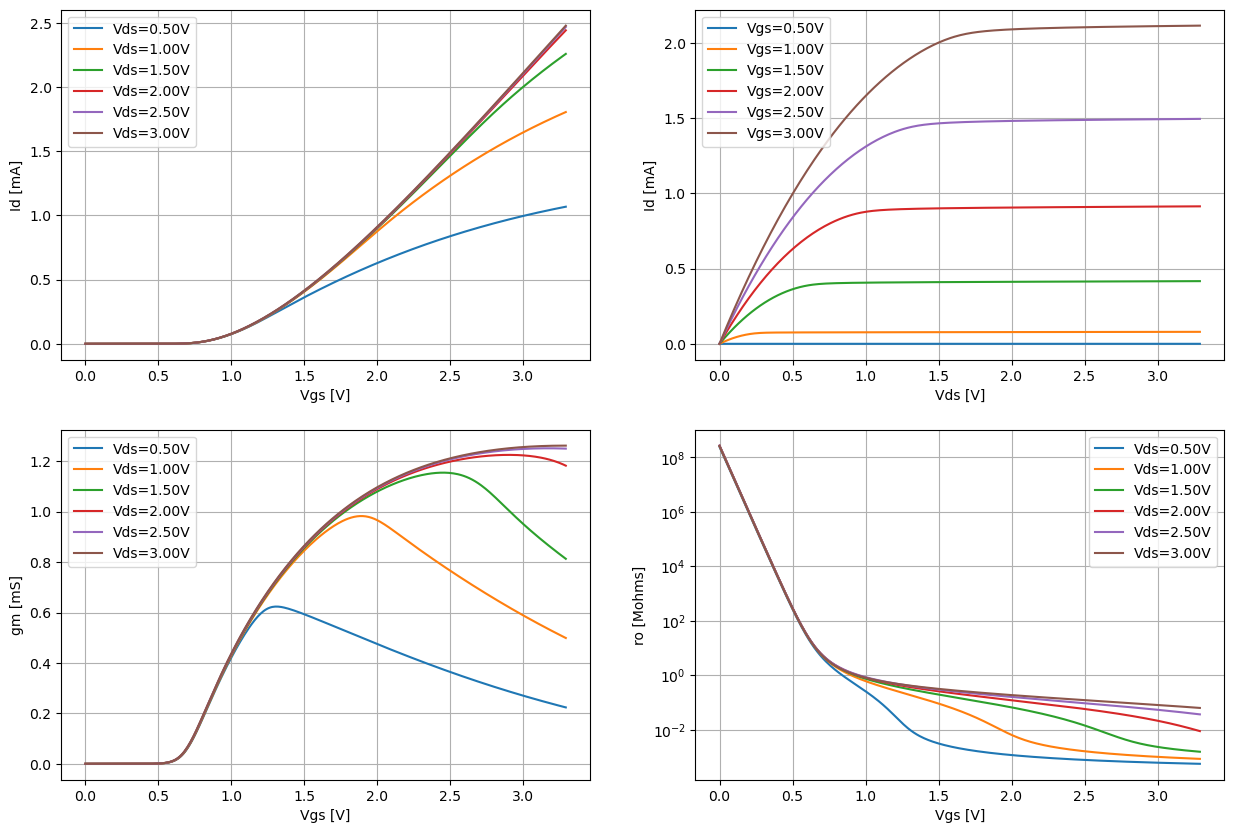

In [3]:
vgs_plt = np.arange(0.5, 3.3, 0.5)
vds_plt = np.arange(0.5, 3.3, 0.5)

plt.figure(figsize=(15,10))

plt.subplot(221)
for vdsn in vds_plt:
    Id = lk.lookup('nfet', 'id', l=l0, vgs=vgs, vds=vdsn, vsb=vsb0)
    plt.plot(vgs, Id*1e3, label='Vds={:.2f}V'.format(vdsn))
plt.ylabel('Id [mA]')
plt.xlabel('Vgs [V]')
plt.grid()
plt.legend()

plt.subplot(222)
for vgsn in vgs_plt:
    Id = lk.lookup('nfet', 'id', l=l0, vgs=vgsn, vds=vds, vsb=vsb0)
    plt.plot(vgs, Id*1e3, label='Vgs={:.2f}V'.format(vgsn))
plt.ylabel('Id [mA]')
plt.xlabel('Vds [V]')
plt.grid()
plt.legend()

plt.subplot(223)
for vdsn in vds_plt:
    gm = lk.lookup('nfet', 'gm', l=l0, vgs=vgs, vds=vdsn, vsb=vsb0)
    plt.plot(vgs, gm*1e3, label='Vds={:.2f}V'.format(vdsn))
plt.ylabel('gm [mS]')
plt.xlabel('Vgs [V]')
plt.grid()
plt.legend()

plt.subplot(224)
for vdsn in vds_plt:
    gds = lk.lookup('nfet', 'gds', l=l0, vgs=vgs, vds=vdsn, vsb=vsb0)
    plt.semilogy(vgs, 1/gds/1e6, label='Vds={:.2f}V'.format(vdsn))
plt.ylabel('ro [Mohms]')
plt.xlabel('Vgs [V]')
plt.grid()
plt.legend()


# Plot intrinsic gain and fT as a function of gm/Id

<string>:1: RuntimeWarning: invalid value encountered in divide


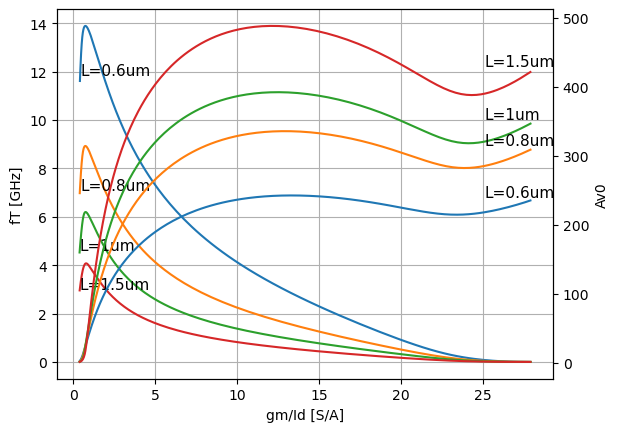

In [4]:
L = [0.6, 0.8, 1, 1.5]
Id_W = [ lk.lookup('nfet', 'id/width', l=l, vgs=vgs, vds=vds0, vsb=vsb0) for l in L ]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for l in L:

    # transconductance efficiency
    gm_Id = lk.lookup('nfet', 'gm/id', l=l, vgs=vgs, vds=vds0, vsb=vsb0)

    # intrinsic gain
    Av0 = lk.lookup('nfet', 'gm/gds', l=l, vgs=vgs, vds=vds0, vsb=vsb0)

    # transit frequency
    fT = lk.lookup('nfet', 'gm/cgg', l=l, vgs=vgs, vds=vds0, vsb=vsb0) / (2 * np.pi) / 1e9

    ax1.plot(gm_Id, fT, label='L={0}um'.format(l))
    ax1.text(1.05*gm_Id[-1], 1.02*fT[-1], 'L={0}um'.format(l), fontsize=11)

    ax2.plot(gm_Id, Av0, label='L={0}um'.format(l))
    ax2.text(0.90*gm_Id[0], 1.02*Av0[0], 'L={0}um'.format(l), fontsize=11)

ax1.set_xlabel('gm/Id [S/A]')
ax1.set_ylabel('fT [GHz]' )
ax2.set_ylabel('Av0')
ax1.grid()

cursor = Cursor(ax2, useblit=True, color='red', linewidth=1)


# Extraction of FET parameters required for hand calculations

## Required physical parameters

### Thermal voltage

$U_T = \frac{kT}{q} \approx 26 \text{ mV}$ at room temperature, where $k = 1.38 \times 10^{-23} \text{ JK}^{-1}$ and $q = 1.602 \times 10^{-19} \text{ C}$

### Electron average mobility

$\mu \approx 400 \frac{\text{ cm}^2}{Vs}$

### Subthreshold slope

### Threshold voltage

### Specific current


# Extracting the Threshold Voltage

## First method for Vth

The method below takes into consideration that in the linear region:

$$
I_D = \mu C_{ox} \frac{W}{L} \left[ V_{DS} (V_{GS} - V_T )-\frac{V_{DS}^2}{2} \right]
$$

And for small values of Vds:

$$
I_D = \mu C_{ox} \frac{W}{L} V_{DS} (V_{GS} - V_T )
$$

where there is a linear relationship between drain current and gate voltage.

Text([0.87], 75.4640024296538, '73uS')

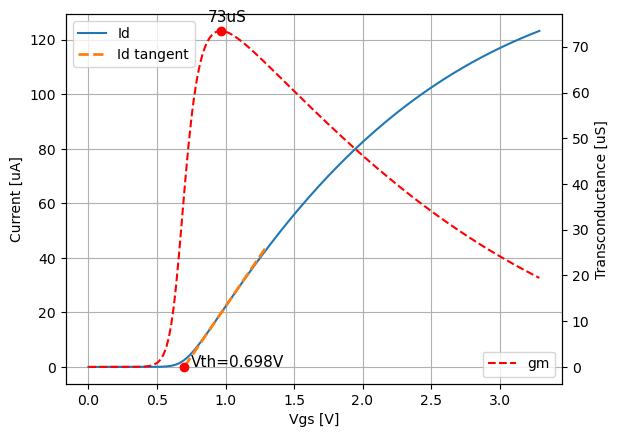

In [5]:
vgs = np.arange(0, 3.3, 10e-3)
vds = np.arange(0, 3.3, 10e-3)

# extracting Id and gm for L = 1um and Vds = 0.1V
Id = lk.lookup('nfet', 'id', l=1, vgs=vgs, vds=50e-3, vsb=vsb0)
gm = lk.lookup('nfet', 'gm', l=1, vgs=vgs, vds=50e-3, vsb=vsb0)

# get 'vgs' voltage at the point of maximum 'gm'
vgs_at_max_gm = vgs[gm == gm.max()]

# get 40mV range around 'gm' peak to extrapolate
dv = 20e-3
idxs = np.logical_and(vgs>vgs_at_max_gm-dv, vgs<vgs_at_max_gm+dv)
vgs_fit = vgs[idxs]
Id_fit = Id[idxs]

# interpolate 'Id(vgs)' with a first order polynomial 
a, b = np.polyfit(vgs_fit, Id_fit, 1)

# threshold voltage is the intecept point at the X-axis which is -b/a for a line
Vth1 = -b/a

# create arrays to plot extrapolated current
vgs_plot = vgs[(vgs>0.7) * (vgs<1.3)]
Id_plot = a*vgs_plot + b

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(vgs, Id*1e6, label='Id')
ax1.set_xlabel('Vgs [V]')
ax1.set_ylabel('Current [uA]')
ax1.grid()

ax1.plot(vgs_plot, Id_plot*1e6, '--', label='Id tangent', linewidth=2)
ax1.legend()

ax1.plot(Vth1, 0, 'ro')
ax1.text(Vth1+50e-3, 0, 'Vth={:.3f}V'.format(Vth1), fontsize=11)

ax2.plot(vgs, gm*1e6, 'r--', label='gm')
ax2.set_xlabel('Vgs [V]')
ax2.set_ylabel('Transconductance [uS]')
ax2.legend(loc='lower right')

ax2.plot(vgs_at_max_gm, gm.max()*1e6, 'ro')
ax2.text(vgs_at_max_gm-100e-3, gm.max()*1e6+2, '{:.0f}uS'.format(gm.max()*1e6), fontsize=11)


## Second method for Vth

From CMOS Analog Design Using All-Region Mosfet Modelling, Chapter 11 at the point: $\frac{gm}{Id} = 0.53 \times \max{\left(\frac{gm}{Id}\right)}$:
$$V_G = V_{th}$$

Trying nearest interpolation method!
Extracted Vth = 0.689 V
From BSIM Vth = 0.689 V


Text(0.7387631351043873, 14.788021155475928, 'Vg=Vth=0.689V')

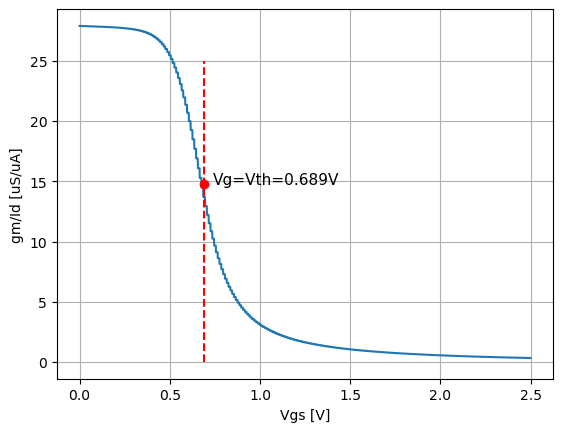

In [83]:
vgs = np.arange(0, 2.5, 1e-3)
l0    = 1
vds0  = 10e-3
vsb0  = 0

# extracting gm/Id and gm for L = 1um and Vds = 4 * Ut
gm_Id = lk.lookup('nfet', 'gm/id', l=l0, vgs=vgs, vds=vds0, vsb=vsb0)

gm_Id_to_vgs = interpolate.interp1d(gm_Id, vgs)

Vth2 = gm_Id_to_vgs(0.5 * max(gm_Id))

print('Extracted Vth = {:.3f} V'.format(Vth2))
print('From BSIM Vth = {:.3f} V'.format(lk.lookup('nfet', 'vt', l=l0, vgs=[Vth2], vds=vds0, vsb=vsb0)))

# TODO: need to review this Is extraction
# Is = 1.13 * lk.lookup('nfet', 'id', l=l0, vgs=[Vth], vds=vds0, vsb=vsb0) / 4
# print('Specific current Is: {:.2f} nA'.format(Is*1e9))

plt.figure()
plt.plot(vgs, gm_Id)
plt.xlabel('Vgs [V]')
plt.ylabel('gm/Id [uS/uA]')
plt.grid()
plt.plot([Vth2, Vth2], [0, 25], 'r--')
plt.plot(Vth2, 0.53 * max(gm_Id), 'ro')
plt.text(Vth2+50e-3, 0.53*max(gm_Id), 'Vg=Vth={:.3f}V'.format(Vth2), fontsize=11)

## Third Method for Vth

Get the $V_{GS}$ where $\frac{d g_m}{d V_{GS}}$ is maximum

Threshold voltage Vth = 0.688 V


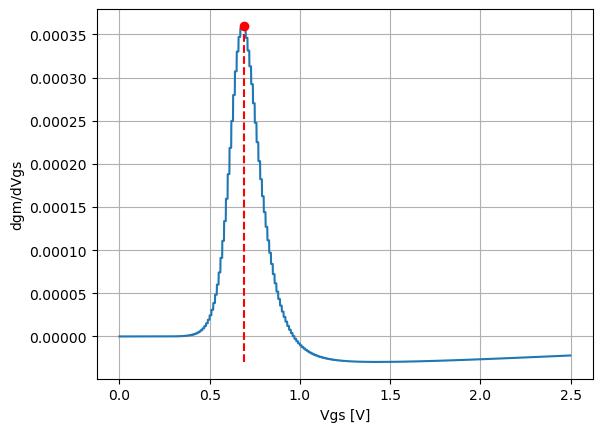

In [50]:
l0 = 1
vds0 = 50e-3
vgs = np.arange(0, 2.5, 1e-3)
gm = lk.lookup('nfet', 'gm', l=l0, vgs=vgs, vds=vds0, vsb=vsb0)

dgm_dvgs = np.diff(gm) / np.diff(vgs)

vgs = vgs[:-1]
dgm_dvgs_to_vgs = interpolate.interp1d(dgm_dvgs, vgs)

Vth3 = dgm_dvgs_to_vgs(dgm_dvgs.max())
print('Threshold voltage Vth = {:.3f} V'.format(Vth3))

plt.figure()
plt.plot(vgs, dgm_dvgs)
plt.plot(Vth3, dgm_dvgs.max(), 'ro')
plt.plot([Vth3, Vth3], [dgm_dvgs.min(), dgm_dvgs.max()], 'r--')
plt.xlabel('Vgs [V]')
plt.ylabel('dgm/dVgs')
plt.grid()

# Extracting the slope factor

$n = 1 + \frac{C_D}{C_{ox}}$, where $C_{ox}$ is the gate-oxide capacitance and $C_D$ is the channel-bulk depletion capacitance (both in $\frac{\text{F}}{\text{cm}^2}$)

The slope factor is the slope of the subthreshold current on deep weak-inversion. The subthreshold slope is usually on the 60mV/dec range

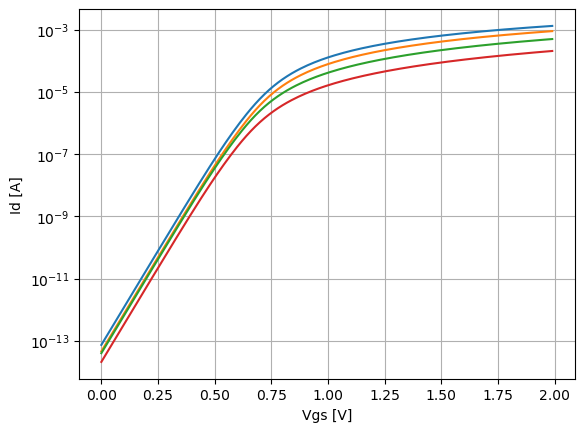

In [51]:
l0 = 1
vds0 = 1.6
vgs = np.arange(0, 2, 10e-3)
L = [0.6, 1, 2, 5]
Id = [ lk.lookup('nfet', 'id', l=l, vgs=vgs, vds=vds0, vsb=vsb0) for l in L ]

plt.figure()
[ plt.semilogy(vgs, ids) for ids in Id ]
plt.xlabel('Vgs [V]')
plt.ylabel('Id [A]')
plt.grid()

Inverting the exponential relationship of the MOS current at deep weak-inversion,
$$
I_D = \exp{\frac{V_{GS}-V_{th}}{n U_T}}
$$
we can find the subthreshold slope, $n$, by taking 2 points of the Id(vgs) characteristisc:
$$
n = \frac{\left( V_{GS1} - V_{GS2} \right)}{ U_T \ln{\frac{I_{D1}}{I_{D2}}}}
$$

In [52]:
# very simple extraction of slope factor 'n' (can be used to test different sections of the subthreshold region and different Ls and VDSs)
vgs1 = 0.5
vgs2 = 0.2
Id1, Id2 = lk.lookup('nfet', 'id', l=l0, vgs=[vgs1, vgs2], vds=vds0, vsb=vsb0)

n = (vgs2 - vgs1) / (Ut * np.log(Id2 / Id1))

print('Slope factor n = {:.2f}'.format(n))

Slope factor n = 1.42


If we take the natural logarithm of $I_D$, a linear extrapolation of the subthreshold region can be performed to find $n$ and $I_{D0}$:
$$
\ln{I_D} = \frac{V_{GS}-V_{th}}{n U_T} + \ln{I_{D0}} \\
$$
where the line coefficients are:
$$
a = \frac{1}{n U_T} \\
b = \ln{I_{D0}} - \left( \frac{V_{th}}{n U_T} \right)
$$


Slope factor n = 1.45
Id0 = 6.81 uA


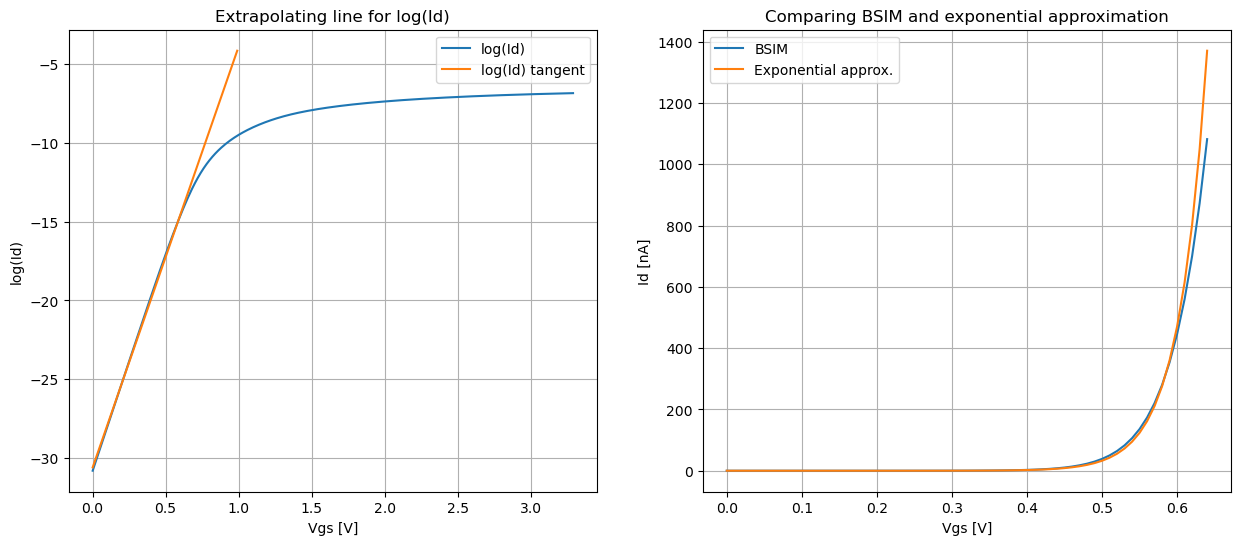

In [6]:
vds0=0.5

lnId = np.log(lk.lookup('nfet', 'id', l=l0, vgs=vgs, vds=vds0, vsb=vsb0))

# extrapolate straight line for subthreshold conduction (up to 0.6V in this case)
idxs = vgs<0.7
vgs_fit  = vgs[idxs]
lnId_fit = lnId[idxs]
a, b = np.polyfit(vgs_fit, lnId_fit, 1)

Vth = 0.7

n = 1 / (a * Ut)
Id0 = np.exp(b + Vth / (n * Ut))

print('Slope factor n = {:.2f}'.format(n))
print('Id0 = {:.2f} uA'.format(Id0*1e6))

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(vgs, lnId, label='log(Id)')
plt.plot(vgs[vgs<1], a*vgs[vgs<1]+b, label='log(Id) tangent')
plt.title('Extrapolating line for log(Id)')
plt.xlabel('Vgs [V]')
plt.ylabel('log(Id)')
plt.grid()
plt.legend()

# extrapolation only happened up to 0.6V. after that a lot of error appears. at 0.65V it is already on the 30% range
plt.subplot(122)
plt.plot(vgs[vgs<0.65], 1e9*lk.lookup('nfet', 'id', l=l0, vgs=vgs[vgs<0.65], vds=vds0, vsb=vsb0), label='BSIM')
plt.plot(vgs[vgs<0.65], 1e9*Id0*np.exp((vgs[vgs<0.65]-Vth)/(n*Ut)), label='Exponential approx.')
plt.title('Comparing BSIM and exponential approximation')
plt.xlabel('Vgs [V]')
plt.ylabel('Id [nA]')
plt.grid()
plt.legend()

# Extracting $\mu C_{ox}$

In deep triode-region:
$$
\frac{d I_{D}}{d V_{DS}} = \mu C_{ox} \frac{W}{L} \left( V_{GS} - V_{th} \right)
$$
Now if we extrapolate with a line of type $y = ax+b$:
$$
a = \mu C_{ox} \frac{W}{L} \\
b = - V_{th} \times a
$$

uCox = 123.75 uA/V^2
Vth = 0.574 V


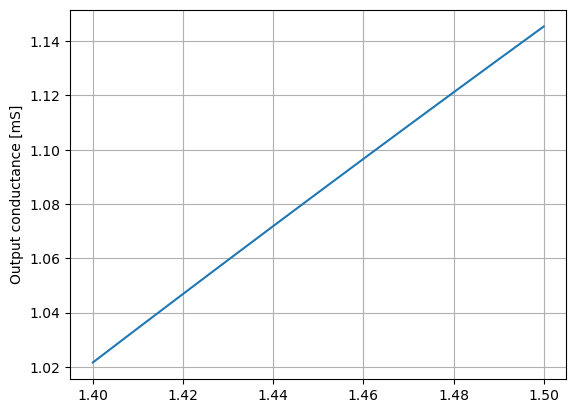

In [7]:
w0 = 10
l0 = 1
vds0 = 10e-3
vgs = np.arange(1.4, 1.5, 10e-3)

gds = lk.lookup('nfet', 'gds', l=l0, vgs=vgs, vds=vds0, vsb=vsb0)

a, b = np.polyfit(vgs, gds, 1)

mu_Cox = a * l0 / w0
Vth4 = - b / a

print('uCox = {:.2f} uA/V^2'.format(mu_Cox*1e6))
print('Vth = {:.3f} V'.format(Vth4))

plt.figure()
plt.plot(vgs, gds*1e3, label='gds')
plt.ylabel('Output conductance [mS]')
plt.grid()

# The EKV model

Main I/V characteristic equation:

$e^{\sqrt{IC}} = e^{v} + 1$

Inversion coefficient:

$IC = \frac{I_{D}}{I_{spec}}$

Normalized voltage:

$v = \frac{V_{GS}-V_{th}}{2 n Ut}$

Specific current:

$I_{spec} = \left( K' \frac{W}{L} \right) \left(2 n Ut\right)^2$

Transconductance parameter:

$K' = \frac{\mu C_{ox}}{2 n}$

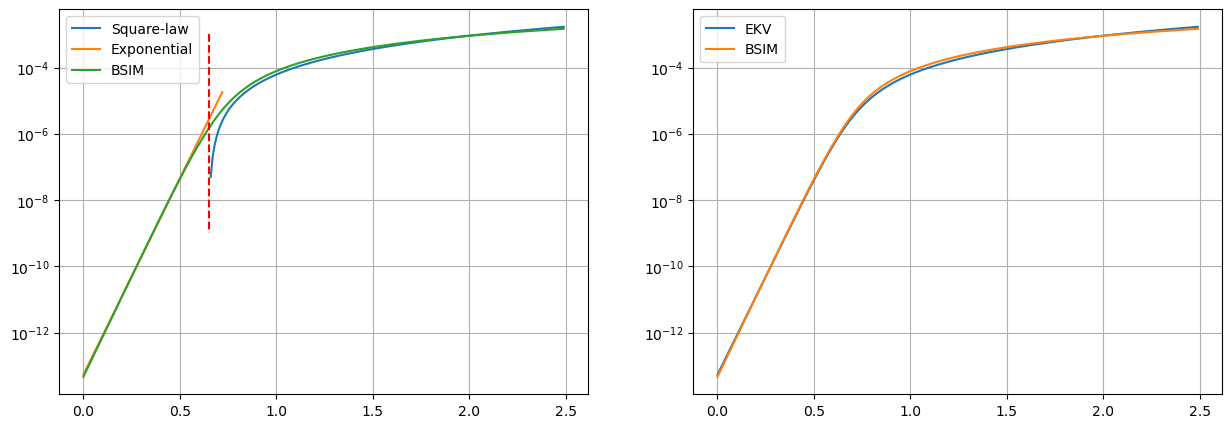

In [8]:
# EKV Tests
w0 = 10.
l0 = 1.
vds0 = 2.
vsb0 = 0.
vgs = np.arange(0, 2.5, 10e-3)
Id = lk.lookup('nfet', 'id', l=l0, vgs=vgs, vds=vds0, vsb=vsb0)

# Need to use a better way to extract these parameters (curve-fitting ??)
Vth = 0.65
K = 50e-6 # mu_Cox / (2 * n)
n = 1.42

# what is the Ispec? Need to find a better way to extract this
Isp = K * (w0 / l0) * (2 * n * Ut)**2

# find inversion coefficient 'ic' for some normalized voltage 'v'
IC = Id / Isp
v = (vgs - Vth) / (2 * n * Ut)

# calculate IC and Id using EKV model
ic = np.array([ np.log(np.exp(vn)+1)**2  for vn in v])
Id_ekv = Isp * ic
Id_si = Isp * v**2
Id_wi = Isp * np.exp(2*v)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.semilogy(vgs[vgs>Vth+1e-3], Id_si[vgs>Vth+1e-3], label='Square-law')
plt.semilogy(vgs[vgs<Vth+80e-3], Id_wi[vgs<Vth+80e-3], label='Exponential')
plt.semilogy(vgs, Id, label='BSIM')
plt.semilogy([Vth, Vth], [1e-3, 1e-9], 'r--')
plt.grid()
plt.legend()

plt.subplot(122)
plt.semilogy(vgs, Id_ekv, label='EKV')
plt.semilogy(vgs, Id, label='BSIM')
plt.grid()
plt.legend()


Text(0.5, 0, 'Vgs [V]')

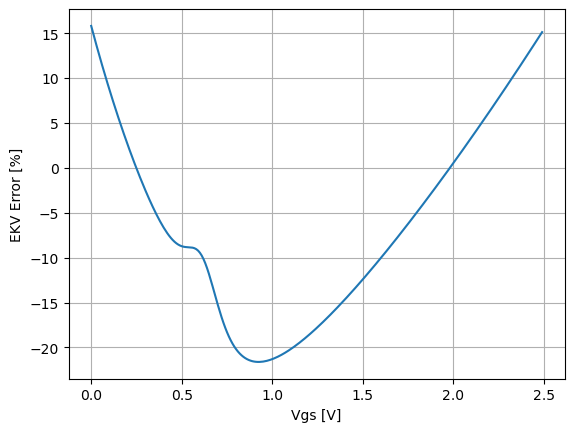

In [9]:
error = (Id_ekv - Id) / Id * 100

plt.figure()
plt.plot(vgs, error)
plt.grid()
plt.ylabel('EKV Error [%]')
plt.xlabel('Vgs [V]')

In [12]:
# define I/V equation from EKV model for root-finding (just a test for fun)
# from scipy.optimize import fsolve
# def ekv_iv(ic, *v):
#     return np.expm1(np.sqrt(ic))-np.exp(v)
# ic = fsolve(ekv_iv, ic_prev, args=vn)

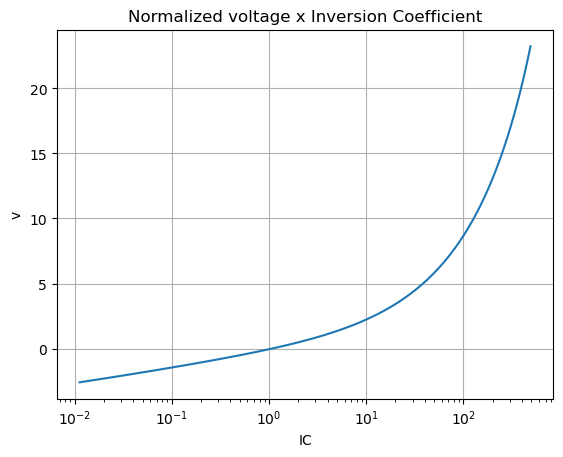

In [67]:
plt.figure()
plt.semilogx(IC[IC>0.01], v[IC>0.01])
plt.title('Normalized voltage x Inversion Coefficient')
plt.xlabel('IC')
plt.ylabel('v')
plt.grid()